In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [2]:
conn_str = os.getenv("CRAIGGER_CONN")  # make sure the tunnel is open
engine = create_engine(conn_str)

In [3]:
df = pd.read_sql(
    """
SELECT "gAddress", "zip", "post_price", "post_date", "post_sqft", "SqftMain", "post_bedroom_count", "NumOfBeds", "quality",
"CurrentRoll_BaseYear",
"CurrentRoll_LandValue",
"CurrentRoll_ImpValue",
"CurrentRoll_LandBaseYear",
"CurrentRoll_ImpBaseYear",
"BaseValue_Land",
"BaseValue_Imp",
"BaseValue_Year",
"post_price" / "post_sqft" AS "rent_per_sqft",
("CurrentRoll_LandValue"::numeric + "CurrentRoll_ImpValue"::numeric)/"post_price" AS "assesment_to_rent_ratio",
("CurrentRoll_LandValue"::numeric + "CurrentRoll_ImpValue"::numeric)/"SqftMain"::numeric AS "assesment_per_sqft"
FROM "tax_results"
JOIN "joined_results" ON "tax_results"."gAddress" = "joined_results"."address"
WHERE "UseType" = 'Single Family Residence' AND "post_bedroom_count" = "NumOfBeds";
""",
    con=engine,
)

In [4]:
df = df[df["assesment_per_sqft"] > 1]
df["years_held"] = df["CurrentRoll_BaseYear"].map(int) - df["BaseValue_Year"].map(int)
df = df.drop_duplicates().dropna()
df.shape

(459, 21)

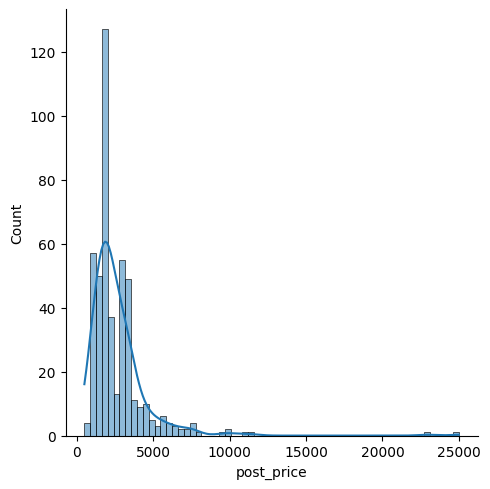

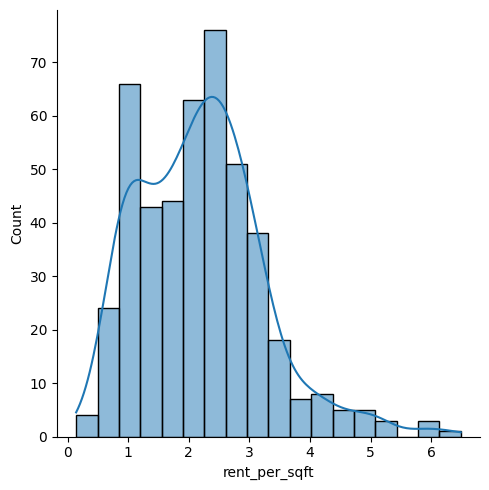

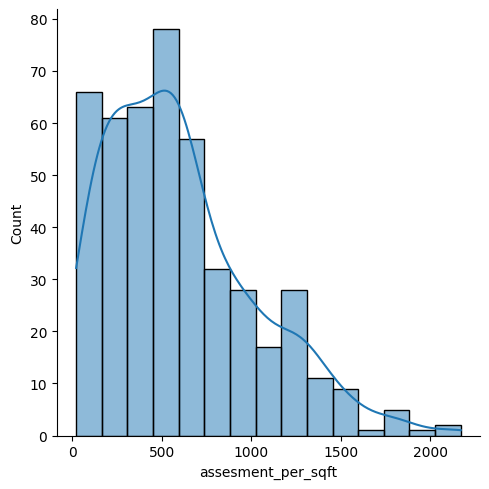

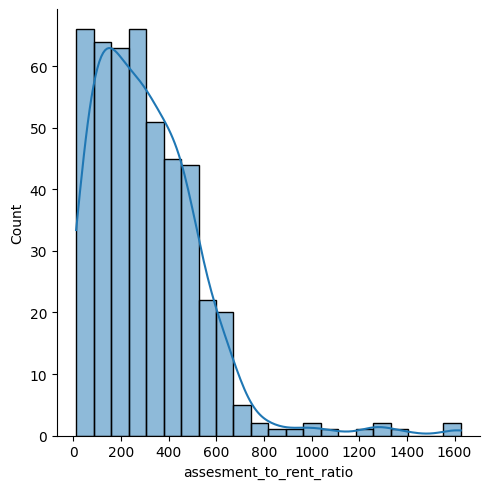

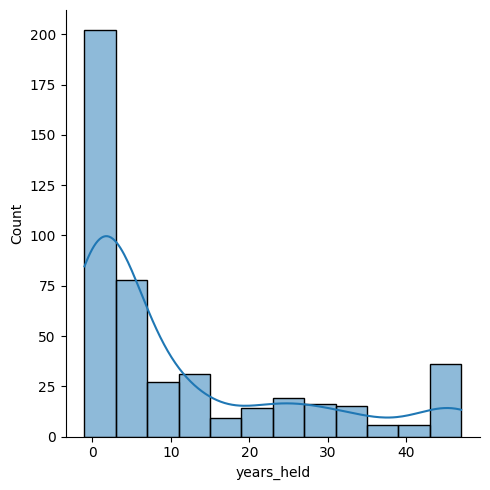

In [5]:
# loop through each column and plot a displot
for column in [
    "post_price",
    "rent_per_sqft",
    "assesment_per_sqft",
    "assesment_to_rent_ratio",
    "years_held",
]:
    sns.displot(df[column], kde=True)

Text(0.5, 1.035, 'Rent per sqft vs. Tax Assessment per sqft\n459 Craigslist rental ads in Los Angeles')

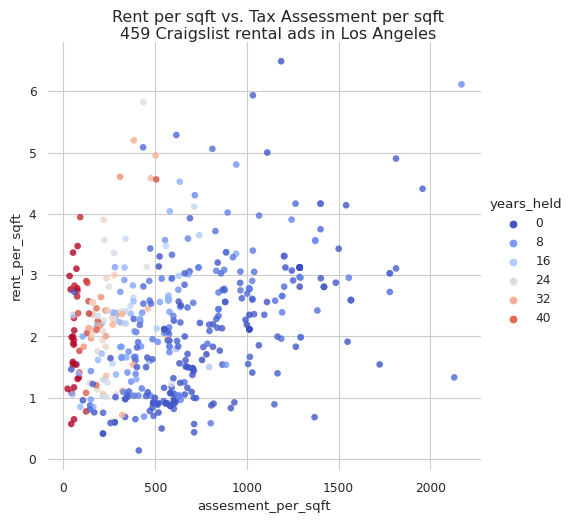

In [11]:
sns.set_theme(style="whitegrid")
sns.set_context("paper")

cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)
# cmap = sns.color_palette("dark:salmon_r", as_cmap=True)

g = sns.relplot(
    data=df,
    x="assesment_per_sqft",
    y="rent_per_sqft",
    hue="years_held",
    linewidth=0,
    alpha=0.8,
    palette=cmap,
)
g.despine(left=True, bottom=True)
plt.suptitle(
    f"Rent per sqft vs. Tax Assessment per sqft\n{len(df)} Craigslist rental ads in Los Angeles",
    y=1.035,
)

In [7]:
df[
    [
        "gAddress",
        "zip",
        "post_date",
        "NumOfBeds",
        "SqftMain",
        "BaseValue_Year",
        "rent_per_sqft",
        "assesment_per_sqft",
        "assesment_to_rent_ratio",
    ]
]

gAddress    zip   post_date  \
0     7143 Woodrow Wilson Dr, Los Angeles, CA 90068,...  90068  2022-02-24   
2              7233 9th Ave, Los Angeles, CA 90043, USA  90043  2022-02-20   
4          3481 E La Jara St, Long Beach, CA 90805, USA  90805  2022-02-28   
5            16927 Casimir Ave, Torrance, CA 90504, USA  90504  2021-05-12   
7            2052 W 77th St, Los Angeles, CA 90047, USA  90047  2022-01-20   
...                                                 ...    ...         ...   
1324        202 California Ave, Monrovia, CA 91016, USA  91016  2021-05-17   
1327        5811 E Rogene St, Long Beach, CA 90815, USA  90815  2020-11-14   
1329        843 Maltman Ave, Los Angeles, CA 90026, USA  90026  2022-01-26   
1332       1107 Maple St, South Pasadena, CA 91030, USA  91030  2021-02-18   
1333         8504 Walnut Dr, Los Angeles, CA 90046, USA  90046  2020-12-17   

     NumOfBeds SqftMain BaseValue_Year  rent_per_sqft  assesment_per_sqft  \
0            1      825           2021       5.933333         1032.363636   
2            4     1649           2017       2.334748          284.517283   
4            4     1549           1999       1.291156          212.834087   
5            3     1276           2019       2.586207          469.568966   
7            3     1264           2020       3.435115          472.886076   
...        ...      ...            ...            ...                 ...   
1324         1      612           2021       2.287582          833.333333   
1327         2     1009           2021       0.996036          722.794846   
1329         1      640           2023       2.968750         1287.475000   
1332         3     1756           2013       2.562642          525.347380   
1333         2      859           2016       2.958333         1292.128056   

      assesment_to_rent_ratio  
0                  173.993871  
2                  121.862078  
4                  164.840000  
5                  181.566667  
7                  132.828444  
...                       ...  
1324               364.285714  
1327               725.671642  
1329               433.675789  
1332               205.002222  
1333               312.658592  

[459 rows x 9 columns]

In [8]:
df["zip"].value_counts()

90026    24
90039    14
91801    14
90068    12
90016    11
         ..
90601     1
90254     1
90048     1
90713     1
91754     1
Name: zip, Length: 145, dtype: int64